## 1. Libraries to Load & Read csv File

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.font_manager import FontProperties
import datetime
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import KFold
import timeit

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('forestfires.csv')

## 2. Data Transformation  

In [2]:
# Get coord
coord = []
for i in range(df.shape[0]):
    coord.append((str(df.loc[i,'X'])+str(df.loc[i,'Y'])))
coord = pd.DataFrame(coord,columns=['coord'])
df = pd.concat([df,coord],axis=1)

# Get fire level
for i in range(df.shape[0]):
    if df.loc[i,'area'] == 0:
        df.loc[i,'nw_area'] = 0
    elif df.loc[i,'area'] > 0 and df.loc[i,'area'] <= 10:
        df.loc[i,['nw_area']] = 1
    elif df.loc[i,'area'] > 10 and df.loc[i,'area'] <= 100:
        df.loc[i,'nw_area']= 2
    elif df.loc[i,'area'] > 100 and df.loc[i,'area'] <= 1000:
        df.loc[i,'nw_area'] = 3
    else:
        df.loc[i,'nw_area'] = 4
        
print(df.nw_area.value_counts())

# Set X, y for classification
X = df.drop(['area','nw_area','X','Y'],axis=1)
Xd = df.drop(['area','nw_area'],axis=1)
yc = df.nw_area
yr = df.area
month_dummies = pd.get_dummies(X['month'])
day_dummies = pd.get_dummies(X['day'])
X = X.join([month_dummies,day_dummies])
X.drop(['month','day'],axis=1,inplace=True)
X = X.values
Xd = Xd.values
yc = yc.values
yr = yr.values

0.0    247
1.0    175
2.0     84
3.0     10
4.0      1
Name: nw_area, dtype: int64


## 3. Decision Tree

(array([0.46153846, 0.38461538, 0.44230769, 0.48076923, 0.53846154,
       0.46153846, 0.30769231, 0.29411765, 0.43137255, 0.39215686]), 0.41945701357466075)


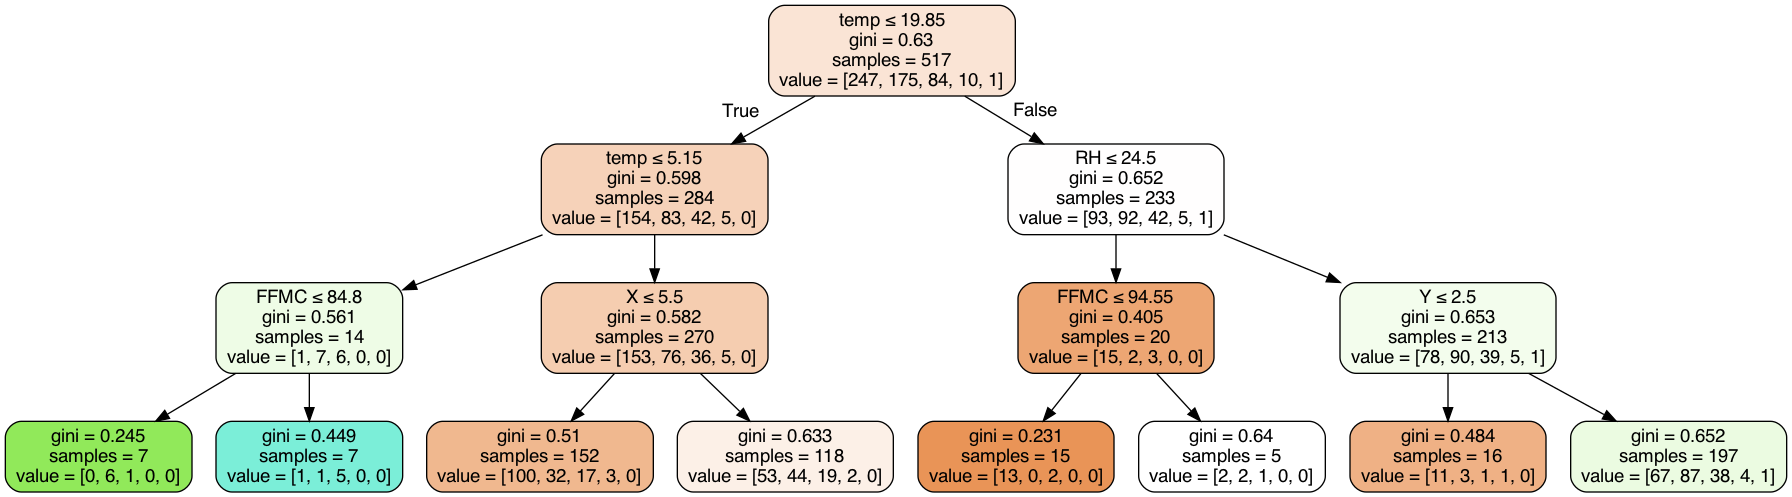

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.model_selection import cross_val_score

Xr = df[['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']]
month_dummies = pd.get_dummies(Xr['month'])
day_dummies = pd.get_dummies(Xr['day'])
Xr = Xr.join([month_dummies,day_dummies])
Xr.drop(['month','day'],axis=1,inplace=True)

dtc5 = DecisionTreeClassifier(max_depth=3)
dtc5.fit(Xr,yc)
dtc5_scores = cross_val_score(dtc5, Xr, yc, cv=10)
print((dtc5_scores, np.mean(dtc5_scores)))

dot_data = StringIO()  

export_graphviz(dtc5, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xr.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

## 4. Dimension Reduction & Exploratory Data Analysis

In [4]:
def get_coord(fire,coord):
    
    if fire == 0:
        fire_status = df[df['nw_area']==0][df['coord']==coord]
    elif fire == 1:
        fire_status = df[df['nw_area']!=0][df['coord']==coord]
        
    return fire_status.sort_values(by=['area'],ascending=False)

def dimension_reduction(method,X,y):
    
    if method == 'PCA':
        
        X_embedded = KernelPCA(n_components=2, kernel='rbf').fit_transform(X)
        
    elif method == 'TSNE':
        
        X_embedded = TSNE(n_components=2).fit_transform(X)
        
    elif method == 'MDS':
        
        X_embedded = MDS(n_components=2).fit_transform(X)

    else:
        
        pass
    
    plt.figure(figsize=(8,5))
    size = 12
    plt.scatter(X_embedded[np.where(y==0)[0].tolist(),0],X_embedded[np.where(y==0)[0].tolist(),1],s=size,label='0',color='blue')
    plt.scatter(X_embedded[np.where(y==1)[0].tolist(),0],X_embedded[np.where(y==1)[0].tolist(),1],s=size,label='1',color='green')
    plt.scatter(X_embedded[np.where(y==2)[0].tolist(),0],X_embedded[np.where(y==2)[0].tolist(),1],s=size,label='2',color='yellow')
    plt.scatter(X_embedded[np.where(y==3)[0].tolist(),0],X_embedded[np.where(y==3)[0].tolist(),1],s=size,label='3',color='orange')
    plt.scatter(X_embedded[np.where(y==4)[0].tolist(),0],X_embedded[np.where(y==4)[0].tolist(),1],s=size,label='4',color='red')
    plt.xlabel(method+'1')
    plt.ylabel(method+'2')
    plt.legend(loc='best')
    plt.show()
    
    return  X_embedded

def tow_feactures_plot(x,y):
    
    plt.figure(figsize=(8,5))
    
    plt.scatter(df[df['area']==0][x],df[df['area']==0][y],label='0',color='blue')
    plt.scatter(df[(df['area']>0)&(df['area']<10)][x],df[(df['area']>0)&(df['area']<10)][y],label='1',color='green')
    plt.scatter(df[(df['area']>10)&(df['area']<100)][x],df[(df['area']>10)&(df['area']<100)][y],label='2',color='yellow')
    plt.scatter(df[(df['area']>100)&(df['area']<1000)][x],df[(df['area']>100)&(df['area']<1000)][y],label='3',color='orange')
    plt.scatter(df[df['area']>1000][x],df[df['area']>1000][y],label='4',color='red')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(loc='best')
    plt.show()
    
get_coord(1,'86')

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,coord,nw_area
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28,86,3.0
235,8,6,aug,sun,91.4,142.4,601.4,10.6,19.6,41,5.8,0.0,196.48,86,3.0
229,8,6,aug,sat,92.2,81.8,480.8,11.9,16.4,43,4.0,0.0,71.30,86,2.0
227,8,6,aug,sat,92.2,81.8,480.8,11.9,20.1,34,4.5,0.0,58.30,86,2.0
220,8,6,aug,sun,90.2,99.6,631.2,6.3,16.2,59,3.1,0.0,32.07,86,2.0
391,8,6,sep,fri,91.1,91.3,738.1,7.2,20.7,46,2.7,0.0,30.18,86,2.0
381,8,6,aug,thu,90.7,194.1,643.0,6.8,16.2,63,2.7,0.0,16.33,86,2.0
203,8,6,oct,wed,91.4,37.9,673.8,5.2,20.2,37,2.7,0.0,13.70,86,2.0
274,8,6,dec,wed,84.0,27.8,354.6,5.3,5.1,61,8.0,0.0,11.19,86,2.0
271,8,6,aug,tue,92.1,152.6,658.2,14.3,20.1,58,4.5,0.0,9.27,86,1.0


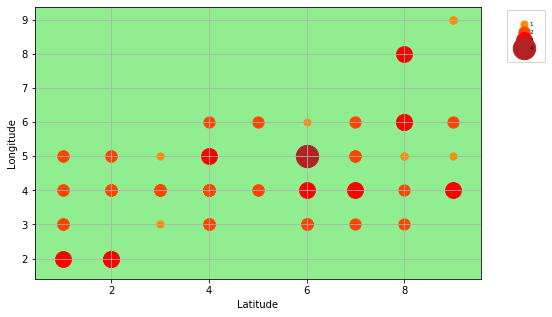

In [5]:
plt.figure(figsize=(8,5))
ax = plt.axes()
ax.set_facecolor('lightgreen')
plt.grid()
#plt.scatter(Xd[np.where(yc==0)[0].tolist(),0],Xd[np.where(yc==0)[0].tolist(),1],s=0,label='0',color='blue')
plt.scatter(Xd[np.where(yc==1)[0].tolist(),0],Xd[np.where(yc==1)[0].tolist(),1],s=50,label='1',color='darkorange')
plt.scatter(Xd[np.where(yc==2)[0].tolist(),0],Xd[np.where(yc==2)[0].tolist(),1],s=125,label='2',color='orangered')
plt.scatter(Xd[np.where(yc==3)[0].tolist(),0],Xd[np.where(yc==3)[0].tolist(),1],s=250,label='3',color='red')
plt.scatter(Xd[np.where(yc==4)[0].tolist(),0],Xd[np.where(yc==4)[0].tolist(),1],s=500,label='4',color='firebrick')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
fontP = FontProperties()
fontP.set_size('xx-small')
plt.legend(loc='best', bbox_to_anchor=(1.15, 1), prop=fontP, borderpad=2, handletextpad=0.0001)
plt.show()

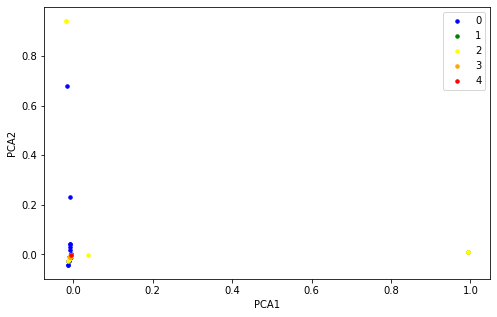

array([[-0.00516126, -0.00436055],
       [-0.00516154, -0.00436091],
       [-0.00555693, -0.00488159],
       ...,
       [-0.00515826, -0.00435675],
       [-0.00515853, -0.00435709],
       [-0.00515826, -0.00435675]])

In [6]:
dimension_reduction('PCA',X,yc)

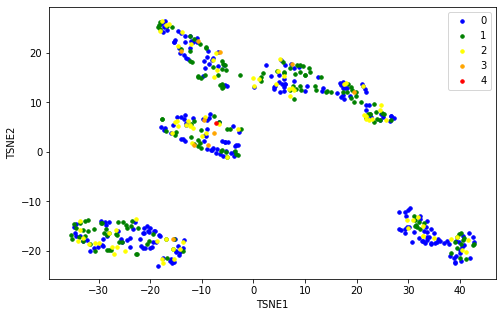

array([[ 32.238804 , -12.921745 ],
       [-14.150967 , -20.236485 ],
       [-15.010209 , -19.89889  ],
       ...,
       [-13.557507 , -18.133135 ],
       [  5.1936345,  12.185988 ],
       [ 30.723085 , -18.234137 ]], dtype=float32)

In [7]:
dimension_reduction('TSNE',X,yc)

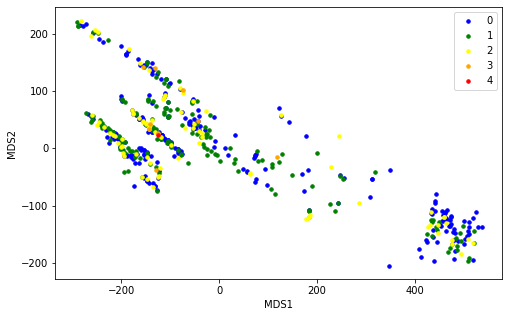

array([[ 436.01782503, -154.3307187 ],
       [-130.0094144 ,  -66.50580348],
       [-147.3428811 ,  -56.47969312],
       ...,
       [-123.91172638,  -50.5314995 ],
       [ -60.56908098,   46.35919967],
       [ 424.70789742, -163.36527452]])

In [8]:
dimension_reduction('MDS',X,yc)

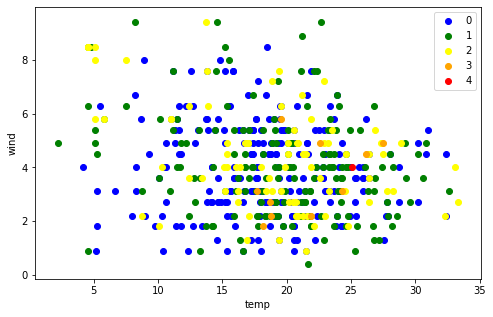

In [9]:
tow_feactures_plot('temp','wind')

In [10]:
df.corr(method='pearson')

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,nw_area
X,1.000000,0.539548,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385,0.074780
Y,0.539548,1.000000,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873,0.034782
FFMC,-0.021039,-0.046308,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122,0.056465
DMC,-0.048384,0.007782,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994,0.069700
DC,-0.085916,-0.101178,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383,0.091114
ISI,0.006210,-0.024488,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258,0.007900
temp,-0.051258,-0.024103,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844,0.069226
RH,0.085223,0.062221,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519,-0.053628
wind,0.018798,-0.020341,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.061119,0.012317,0.063852
rain,0.065387,0.033234,0.056702,0.074790,0.035861,0.067668,0.069491,0.099751,0.061119,1.000000,-0.007366,0.048518


## 5. Random Forest

In [11]:
params = [{
    'max_depth':list(range(10,25)),
    'criterion':['gini', 'entropy'],
    'max_features':['auto','sqrt','log2'],
    'bootstrap':[True, False]
    }]  

forest = GridSearchCV(RandomForestClassifier(),params)

forest.fit(X, yc)

best = forest.best_params_
bestforest = RandomForestClassifier(criterion=best['criterion'], 
                                    max_depth=best['max_depth'], 
                                    max_features=best['max_features'],
                                    bootstrap=best['bootstrap']).fit(X, yc)

confusionMatrix = pd.DataFrame(confusion_matrix(yc, bestforest.predict(X),labels=[0,1,2,3,4]),
             index=['Actual 0','Actual 1','Actual 2','Actual 3','Actual 4'],
             columns=['Predict 0','Predict 1','Predict 2','Predict 3','Predict 4'])

print('Best Parameters:\n',best)
print('Score:',bestforest.score(X, yc))
print('Confusion Matrix:\n',confusionMatrix)

Best Parameters:
 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2'}
Score: 0.9342359767891683
Confusion Matrix:
           Predict 0  Predict 1  Predict 2  Predict 3  Predict 4
Actual 0        245          2          0          0          0
Actual 1          4        170          1          0          0
Actual 2         10         10         64          0          0
Actual 3          6          0          0          4          0
Actual 4          1          0          0          0          0


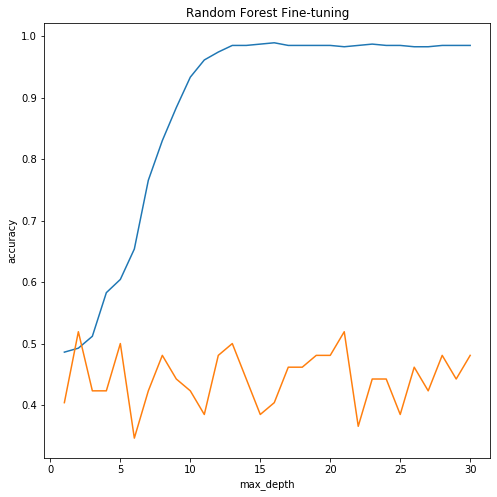

1


In [12]:
forest_train_score = []
forest_test_score = []

for i in range(1,31):
    X_train, X_test, yc_train, yc_test = train_test_split(X, yc, test_size=0.10, random_state=i)
    forest = RandomForestClassifier(criterion=best['criterion'], 
                                    max_depth=i, 
                                    max_features=best['max_features'],
                                    bootstrap=best['bootstrap']).fit(X_train, yc_train)
    train_score = forest.score(X_train, yc_train)
    test_score = forest.score(X_test, yc_test)
    forest_train_score.append(train_score)
    forest_test_score.append(test_score)
    
plt.figure(figsize=(8,8))
plt.plot(range(1,31),forest_train_score)
plt.plot(range(1,31),forest_test_score)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Random Forest Fine-tuning')
plt.show()
print(forest_test_score.index(max(forest_test_score)))

In [13]:
def mis_class(X,yr,yc,label):
    
    mis_idx = []
    for i in range(len(yc.tolist())):
        if bestforest.predict(X).tolist()[i] == label and yc.tolist()[i] != label:
            mis_idx.append(i)
    if label == 0:
        base = 0
    elif label == 1:
        base = 5
    elif label == 2:
        base = 55
    elif label == 3:
        base = 550
    elif label == 4:
        base = 1000
    else:
        pass
    
    mis = yr[mis_idx].tolist()
    MAE = sum([abs(i-base) for i in mis])/len(mis)
    MSE = sum([(i-base)**2 for i in mis])/len(mis)
    baseline = sum([(i-np.mean(mis))**2 for i in mis])/len(mis)
    r_square = 1 - MSE/baseline
    
    return mis, r_square, baseline, MAE, MSE

In [14]:
mae4 = abs(max(yr) - 1000)
mse4 = (max(yr) - 1000)**2
baseline4 = (max(yr) - 1000)**2
r_square4 = 1 - mse4/baseline4
print('Error of label 4:',(mae4,mse4,baseline4,r_square4))

Error of label 4: (90.83999999999992, 8251.905599999985, 8251.905599999985, 0.0)


In [15]:
def error_label4(X_test,yr_test):
    
    mis_idx = yr_test[np.where(bestforest.predict(X_test)==4)]
    mis = yr[mis_idx].tolist()
    MAE = sum([abs(i-1000) for i in mis])/len(mis)
    MSE = sum([(i-1000)**2 for i in mis])/len(mis)
    baseline = sum([(i-np.mean(mis))**2 for i in mis])/len(mis)
    r_square = 1 - MSE/baseline
    
    return mis_idx, mis, MAE, MSE, baseline, r_square

In [16]:
def filter_pred_idx(X,yr,label):
    
    idxpred = [idx for idx, value in enumerate(bestforest.predict(X).tolist()) if value == label]
    yr_class = yr[idxpred]
    X_class = X[idxpred]
    return X_class, yr_class

In [17]:
X1, y1 = filter_pred_idx(X,yr,1)
X2, y2 = filter_pred_idx(X,yr,2)
X3, y3 = filter_pred_idx(X,yr,3)

## 6. Polynomial Regression

In [18]:
model=make_pipeline(PolynomialFeatures(4), linear_model.Ridge(alpha=0.3))

model.fit(X1,y1)
R_squre = model.score(X1,y1)
MAE = mean_absolute_error(y1,model.predict(X1))
RMSE = mean_squared_error(y1, model.predict(X1), squared=False)
print('R-square:',R_squre)
print('MAE:',MAE)
print('RMSE:',RMSE)

R-square: 0.9792485312716176
MAE: 0.2511568791938993
RMSE: 0.9159411958184623


In [19]:
def regressors_gridsearch(X,y,assign_model,degree):
      
    params = {'normalize':[True,False],
              'alpha':[0,0.01,0.05,0.1,0.5,1,5]}
    info = []
    for i in params['normalize']:
        for j in params['alpha']:
            
            if assign_model == 'Lasso':
                regressor = make_pipeline(PolynomialFeatures(degree), 
                                linear_model.Lasso(normalize=i,alpha=j))
                
            elif assign_model == 'Ridge':
                regressor = make_pipeline(PolynomialFeatures(degree), 
                                linear_model.Ridge(normalize=i,alpha=j))
            else:
                pass
            
            regressor.fit(X,y)
            pred = regressor.predict(X)
            R_squre = regressor.score(X,y)
            MAE = mean_absolute_error(y,regressor.predict(X))
            MSE = mean_squared_error(y,regressor.predict(X))
            Baseline = mean_squared_error(y,np.repeat(np.mean(y),len(y)))
            info.append([assign_model,degree,i,j,R_squre,MAE,MSE,Baseline,pred])
            
  
    df = pd.DataFrame(info,columns=['model','degree','normalize','alpha','R_square','MAE','MSE','Baseline Error','Pred'])
    
    return df

def regressors_gridsearch_extend(X,y):
    
    info = []
    for model in ['Lasso','Ridge']:
        for degree in list(range(1,6)):
            
            info = info + regressors_gridsearch(X,y,model,degree).values.tolist()
            
    df = pd.DataFrame(info,columns=['model','degree','normalize','alpha','R_square','MAE','MSE','Baseline Error','Pred'])
    
    return df           

In [20]:
reg = regressors_gridsearch_extend(X1,y1)
reg

,model,degree,normalize,alpha,R_square,MAE,MSE,Baseline Error,Pred
0,Lasso,1,True,0.00,0.081800,3.325905,37.121341,40.428381,"[1.2882539902859262, 6.561262446790487, 6.9164..."
1,Lasso,1,True,0.01,0.051907,3.370923,38.329863,40.428381,"[4.440324853757565, 6.211564737840511, 7.04445..."
2,Lasso,1,True,0.05,0.002906,3.503040,40.310914,40.428381,"[4.72623776574471, 4.72623776574471, 4.9571535..."
3,Lasso,1,True,0.10,0.000000,3.502817,40.428381,40.428381,"[4.760494505494505, 4.760494505494505, 4.76049..."
4,Lasso,1,True,0.50,0.000000,3.502817,40.428381,40.428381,"[4.760494505494505, 4.760494505494505, 4.76049..."
...,...,...,...,...,...,...,...,...,...
135,Ridge,5,False,0.05,0.976719,0.334055,0.941220,40.428381,"[0.2793891746464112, 0.5047269374975656, -0.03..."
136,Ridge,5,False,0.10,0.976719,0.334055,0.941220,40.428381,"[0.2793891746464112, 0.5047269374975656, -0.03..."
137,Ridge,5,False,0.50,0.976719,0.334055,0.941220,40.428381,"[0.2793891746464112, 0.5047269374975656, -0.03..."
138,Ridge,5,False,1.00,0.976719,0.334055,0.941220,40.428381,"[0.2793891746464112, 0.5047269374975656, -0.03..."


In [22]:
kfold = KFold(10, True, 99)
infoPoly = []
model=make_pipeline(PolynomialFeatures(3), linear_model.Ridge(alpha=0.3))

for train, test in kfold.split(df):

    train = train.tolist()
    test = test.tolist()
    X_train=X[train] 
    X_test=X[test]
    yr_train=yr[train] 
    yr_test=yr[test]
    start = timeit.default_timer()

    model.fit(X_train,yr_train)
    stop = timeit.default_timer()
    timedif = stop - start
    R_squre_test = model.score(X_test,yr_test)
    MAE_test = mean_absolute_error(yr_test,model.predict(X_test))
    RMSE_test = mean_squared_error(yr_test, model.predict(X_test), squared=False)
    MSE_test = mean_squared_error(yr_test, model.predict(X_test))
    infoPoly.append([MAE_test, MSE_test, RMSE_test, R_squre_test, timedif])
    
infoPoly = pd.DataFrame(infoPoly, columns=['MAE','MSE','RMSE','R2', 'Runtime'])
infoPoly


,MAE,MSE,RMSE,R2,Runtime
0,255.360417,1.107601e+05,332.806388,-180.082061,0.063824
1,452.270036,7.260670e+05,852.095663,-317.513826,0.048988
2,641.335945,2.437504e+06,1561.250713,-3675.883724,0.060371
3,633.064531,1.070807e+06,1034.798079,-1043.052860,0.058658
4,389.902473,5.108266e+05,714.721376,-567.997149,0.056715
5,377.089067,4.660691e+05,682.692503,-43.439196,0.094094
6,312.579812,3.608735e+05,600.727477,-1604.494805,0.102436
7,549.147603,5.178762e+06,2275.689353,-16739.514769,0.135817
8,293.342637,2.921547e+05,540.513400,-306.767867,0.075027
9,230.734947,1.816895e+05,426.250563,-6.975764,0.112323


## 7. Dimensionality Reduction Polynomial Regression

## 7.1 PCA Polynomial Regression

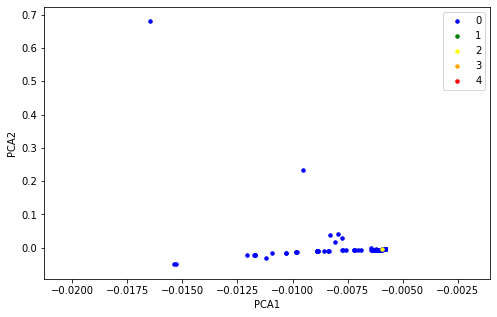

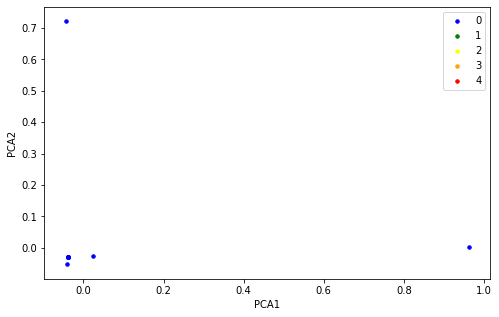

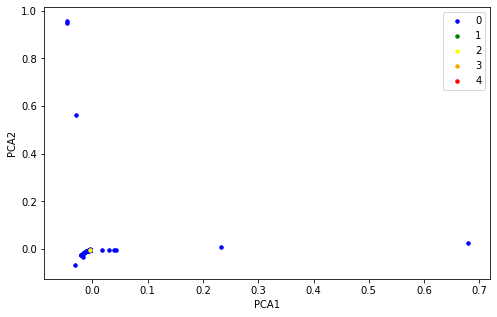

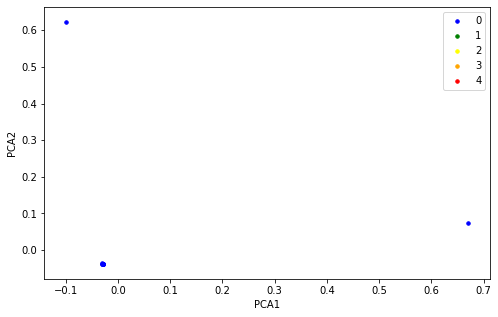

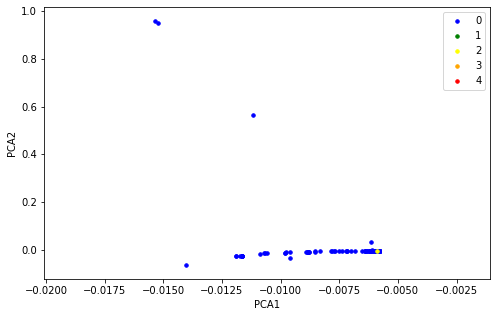

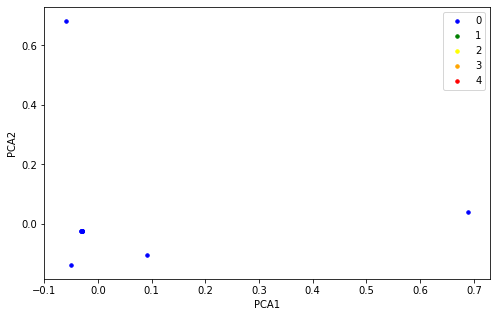

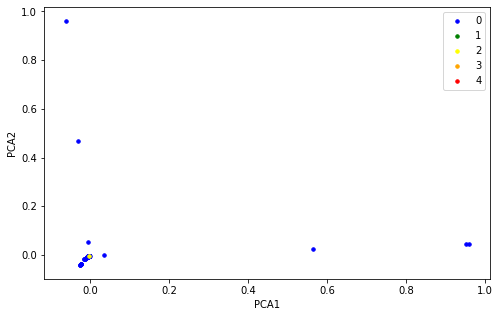

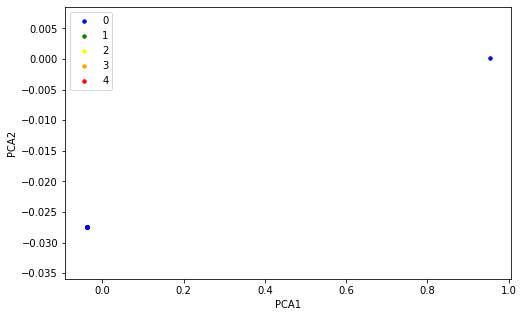

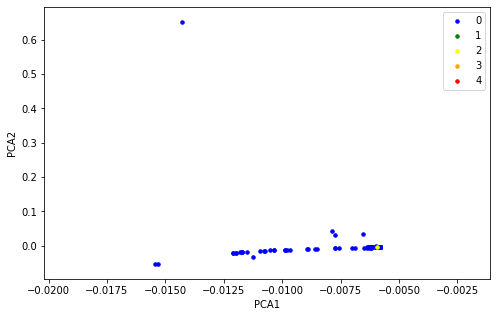

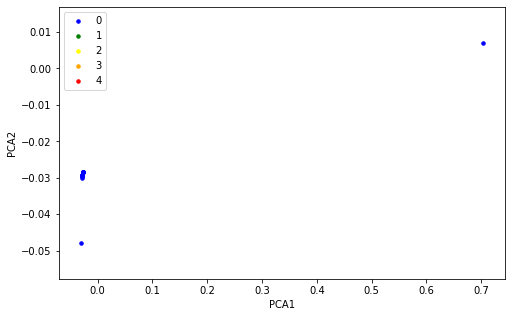

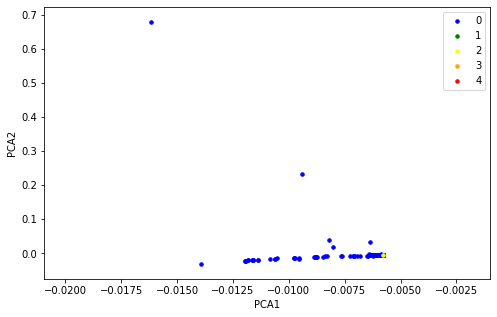

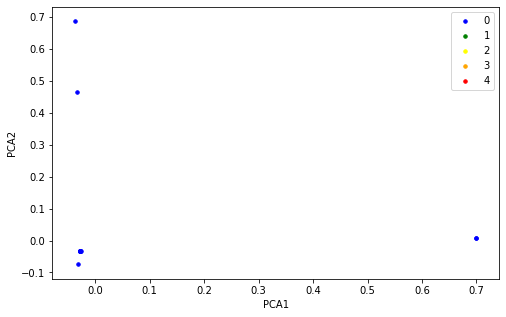

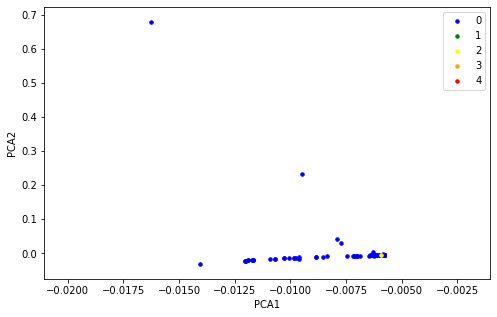

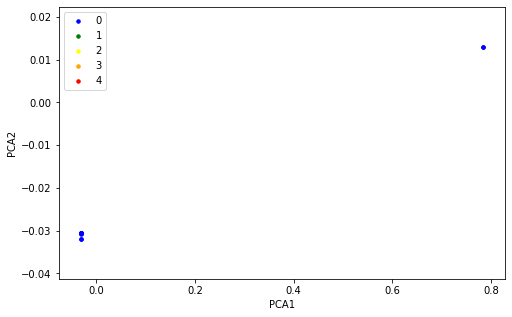

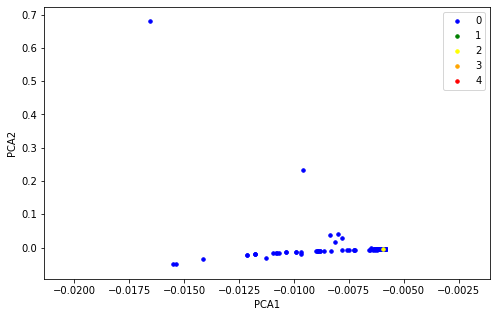

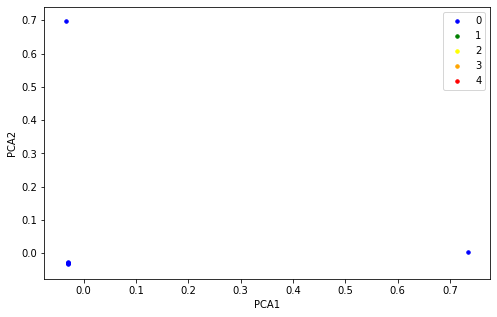

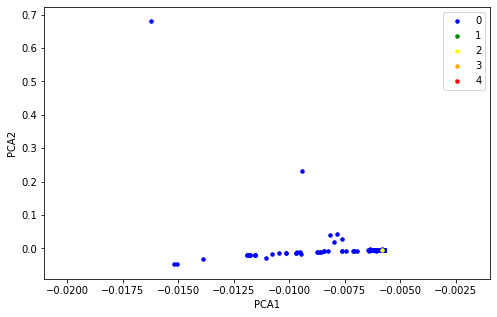

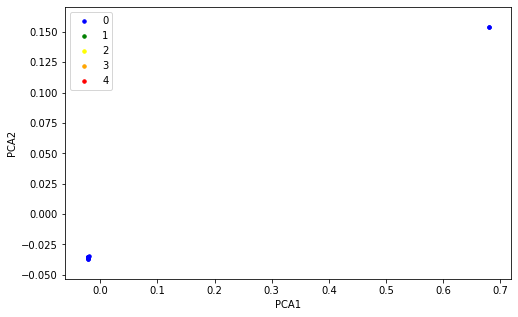

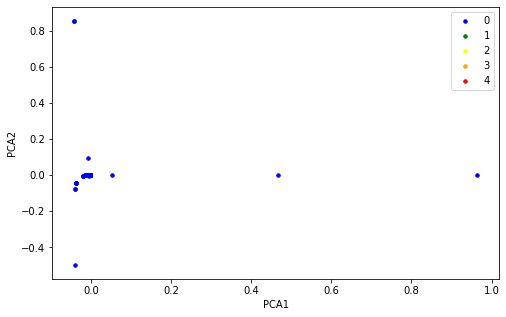

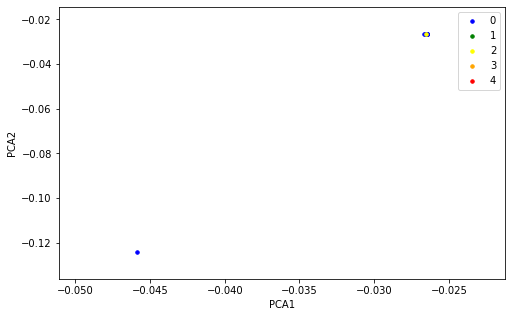

,MAE,MSE,RMSE,R2,Runtime
0,14.525833,647.038413,25.436950,-0.057845,0.001408
1,21.994484,2312.586917,48.089364,-0.014494,0.001116
2,14.907588,680.693099,26.090096,-0.026800,0.001189
3,16.265129,1033.779224,32.152437,-0.007950,0.002234
4,16.333701,908.675775,30.144249,-0.012151,0.001175
5,25.908384,10551.134393,102.718715,-0.006040,0.002429
6,13.121701,253.039379,15.907212,-0.125750,0.001170
7,14.156367,340.491361,18.452408,-0.100649,0.001304
8,17.443798,972.502207,31.184968,-0.024474,0.001428
9,31.731245,23081.179816,151.924915,-0.013212,0.001714


In [23]:
kfold = KFold(10, True, 99)
infoPolyPCA = []
model=make_pipeline(PolynomialFeatures(3), linear_model.Ridge(alpha=0.3))

for train, test in kfold.split(df):

    train = train.tolist()
    test = test.tolist()
    X_train=X[train] 
    X_test=X[test]
    yr_train=yr[train] 
    yr_test=yr[test]
    X_PCA_train = dimension_reduction('PCA',X_train,yr_train)
    X_PCA_test = dimension_reduction('PCA',X_test,yr_test)

    start = timeit.default_timer()

    model.fit(X_PCA_train,yr_train)
    stop = timeit.default_timer()
    timedif = stop - start
    R_squre_test = model.score(X_PCA_test,yr_test)
    MAE_test = mean_absolute_error(yr_test,model.predict(X_PCA_test))
    RMSE_test = mean_squared_error(yr_test, model.predict(X_PCA_test), squared=False)
    MSE_test = mean_squared_error(yr_test, model.predict(X_PCA_test))
    infoPolyPCA.append([MAE_test, MSE_test, RMSE_test, R_squre_test, timedif])
    
infoPolyPCA = pd.DataFrame(infoPolyPCA, columns=['MAE','MSE','RMSE','R2', 'Runtime'])
infoPolyPCA

## 7.2 t-SNE Polynomial Regression

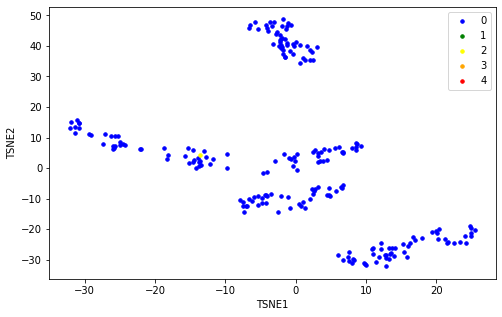

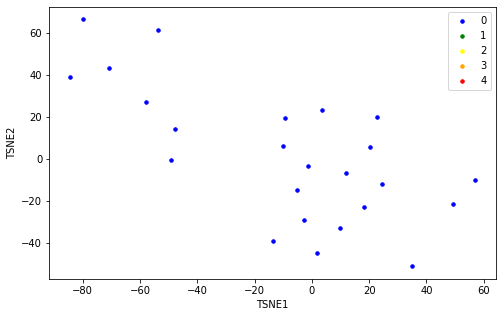

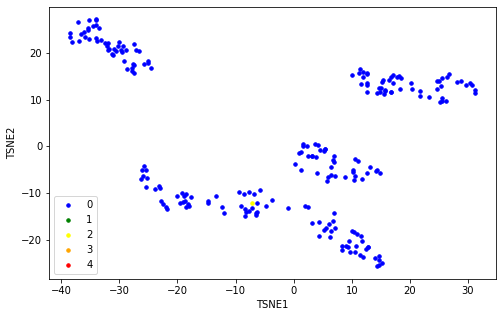

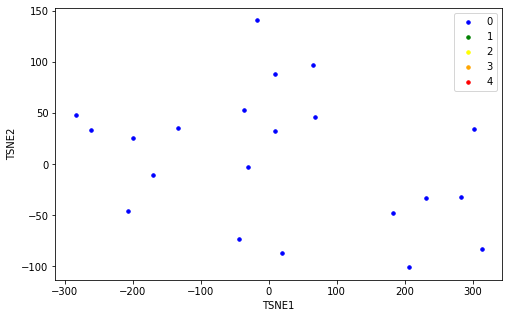

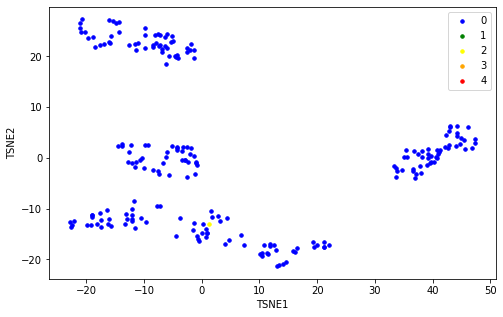

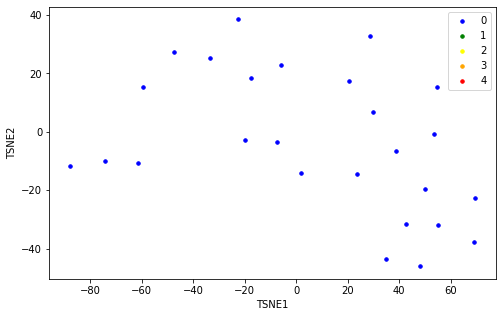

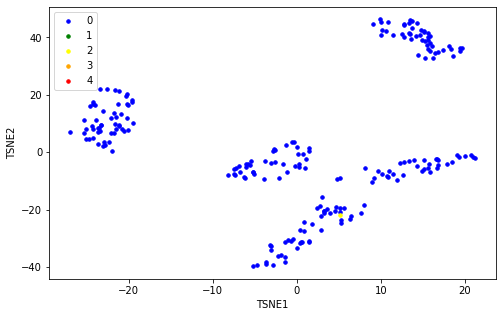

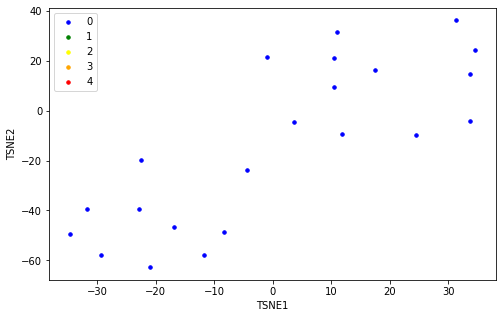

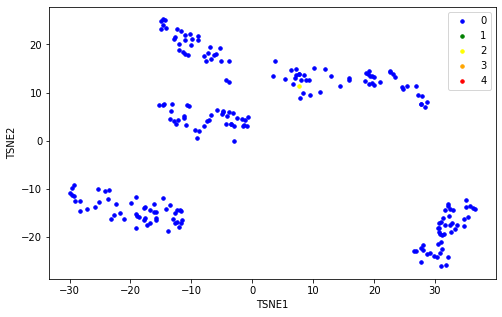

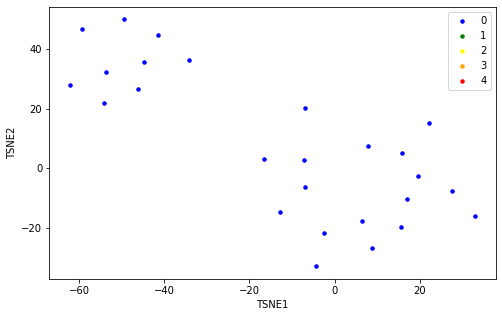

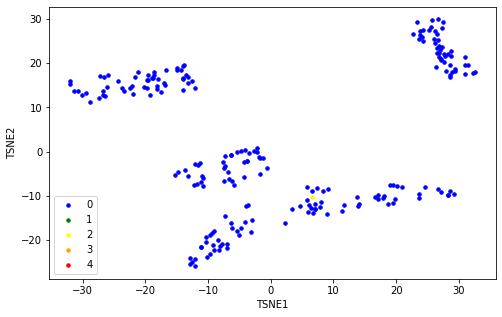

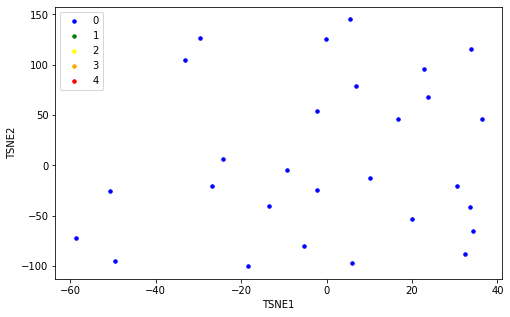

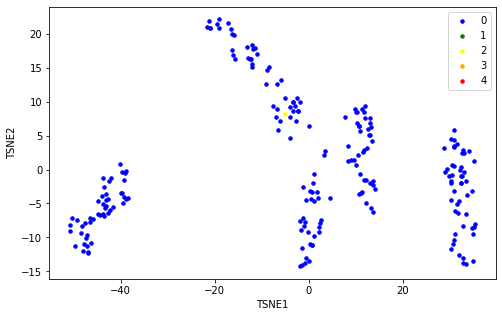

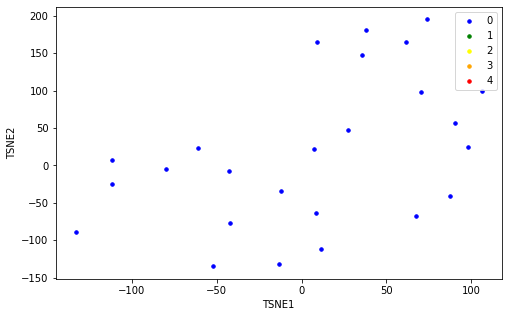

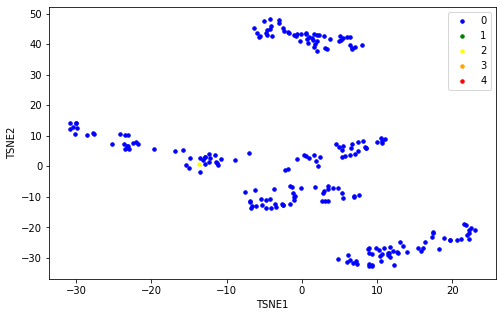

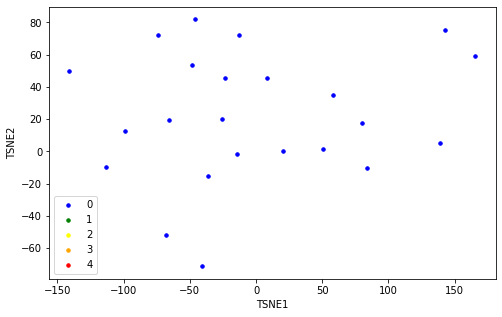

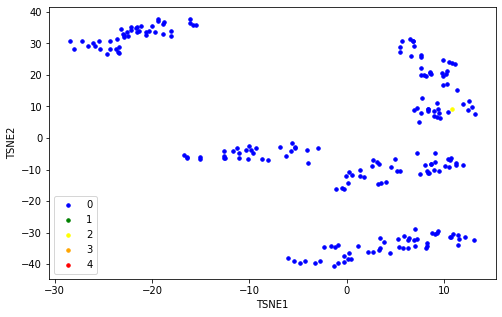

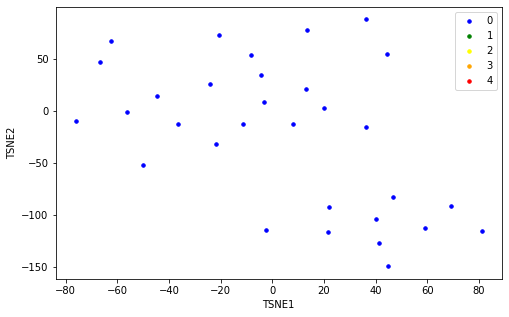

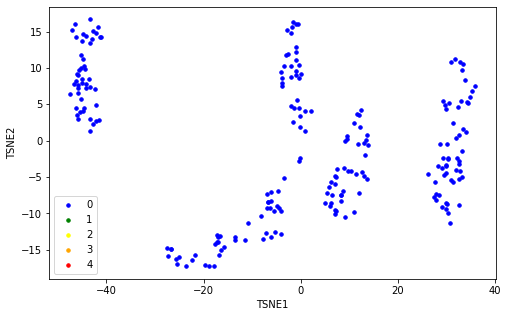

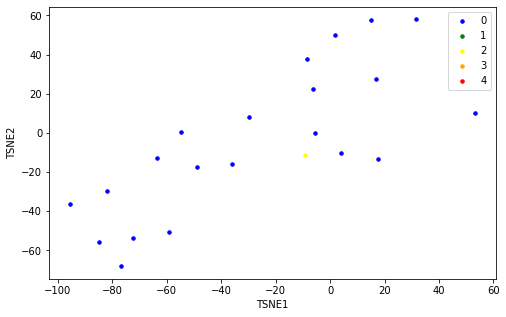

,MAE,MSE,RMSE,R2,Runtime
0,105.486594,2.857181e+04,169.031988,-45.712156,0.021701
1,4775.208700,4.583752e+07,6770.341468,-20107.178227,0.001340
2,94.991641,2.251094e+04,150.036468,-32.956918,0.010818
3,33.129382,2.243784e+03,47.368602,-1.187723,0.001410
4,61.989435,1.023234e+04,101.155052,-10.397555,0.001383
5,744.533644,1.450762e+06,1204.475943,-137.328667,0.001315
6,2008.087723,1.455785e+07,3815.474494,-64765.588267,0.001401
7,1938.088041,1.164563e+07,3412.569811,-37643.882164,0.001509
8,136.045299,3.814564e+04,195.309098,-39.184197,0.001274
9,357.348291,4.299517e+05,655.707049,-17.873917,0.001592


In [24]:
kfold = KFold(10, True, 99)
infoPolytSNE = []
model=make_pipeline(PolynomialFeatures(3), linear_model.Ridge(alpha=0.3))

for train, test in kfold.split(df):

    train = train.tolist()
    test = test.tolist()
    X_train=X[train] 
    X_test=X[test]
    yr_train=yr[train] 
    yr_test=yr[test]
    X_tSNE_train = dimension_reduction('TSNE',X_train,yr_train)
    X_tSNE_test = dimension_reduction('TSNE',X_test,yr_test)

    start = timeit.default_timer()

    model.fit(X_tSNE_train,yr_train)
    stop = timeit.default_timer()
    timedif = stop - start
    R_squre_test = model.score(X_tSNE_test,yr_test)
    MAE_test = mean_absolute_error(yr_test,model.predict(X_tSNE_test))
    RMSE_test = mean_squared_error(yr_test, model.predict(X_tSNE_test), squared=False)
    MSE_test = mean_squared_error(yr_test, model.predict(X_tSNE_test))
    infoPolytSNE.append([MAE_test, MSE_test, RMSE_test, R_squre_test, timedif])
    
infoPolytSNE = pd.DataFrame(infoPolytSNE, columns=['MAE','MSE','RMSE','R2', 'Runtime'])
infoPolytSNE

## 7.3 MDS Polynomial Regression

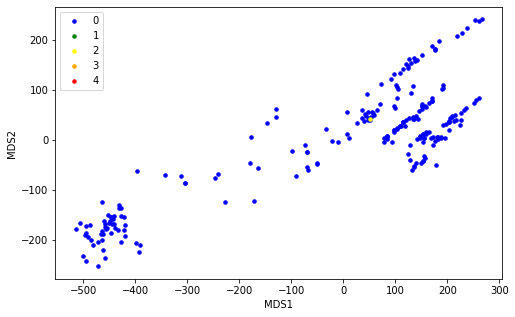

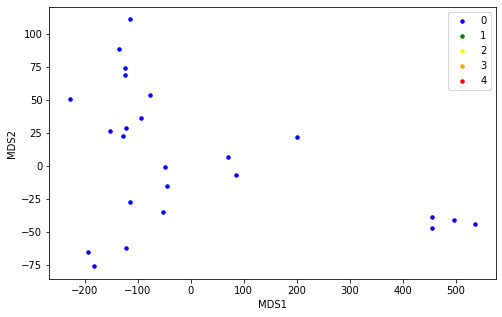

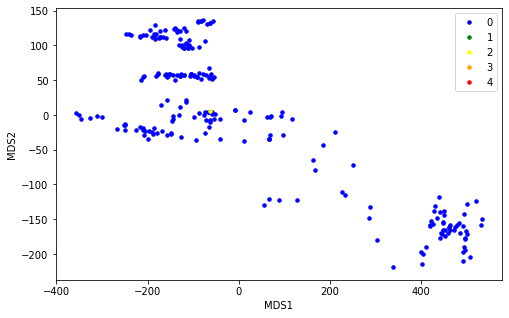

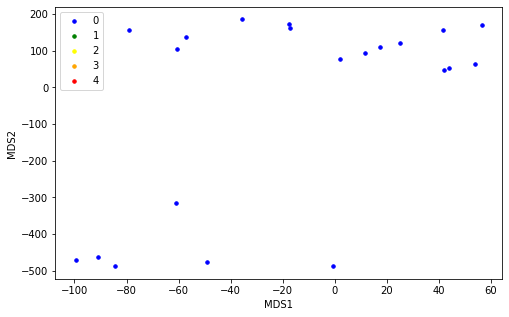

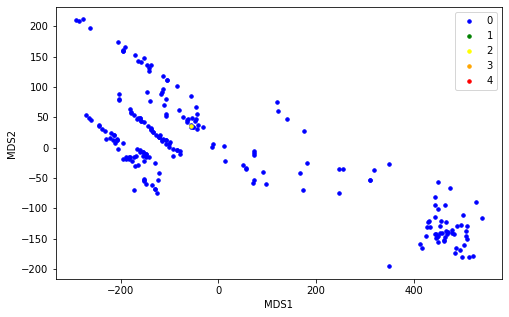

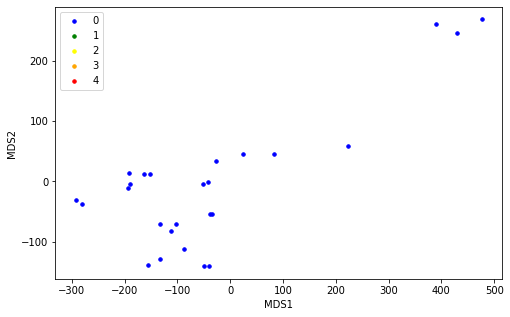

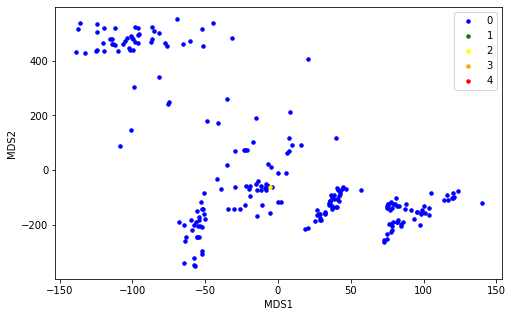

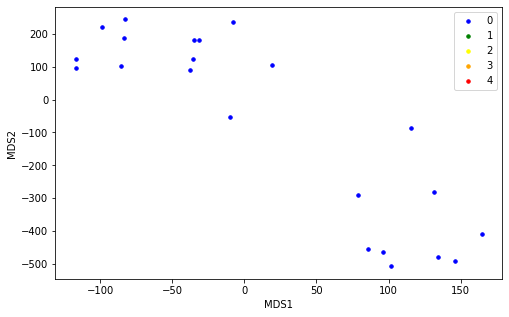

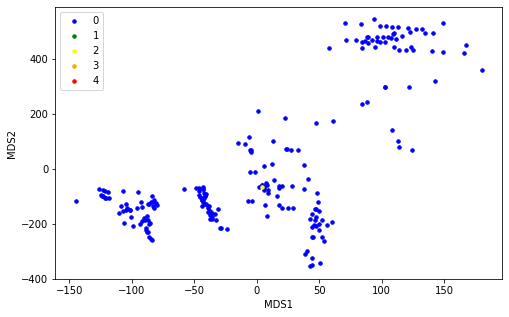

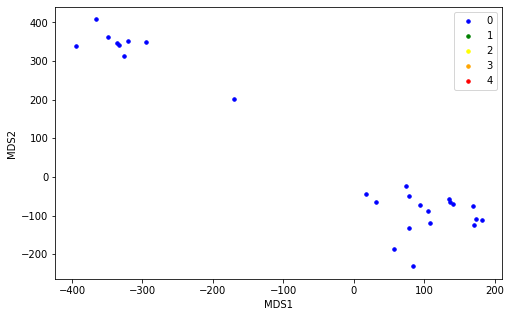

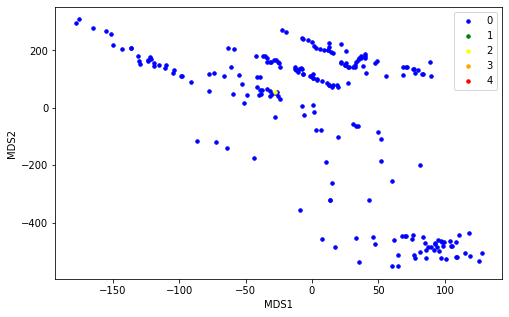

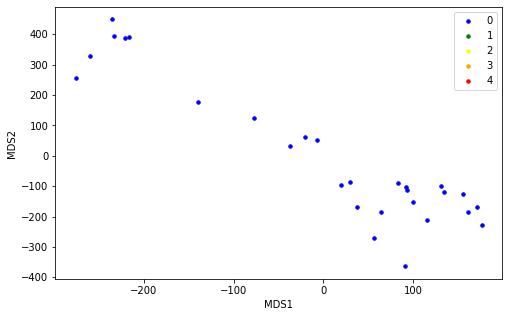

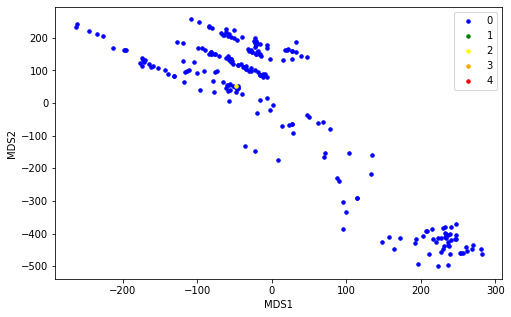

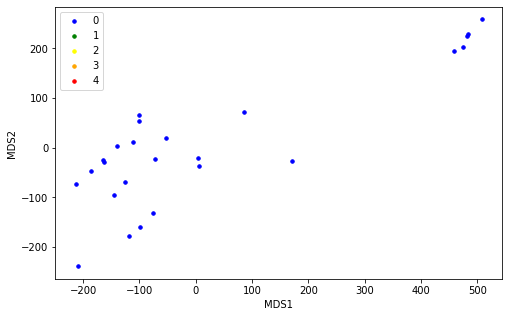

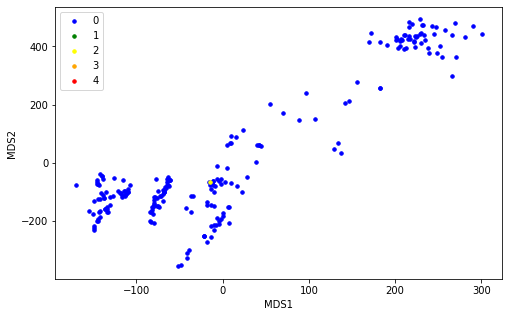

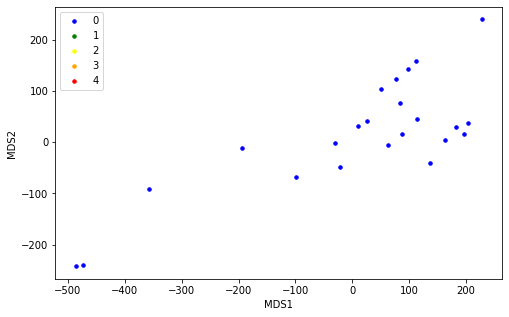

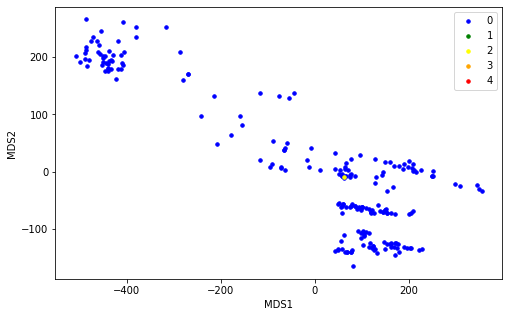

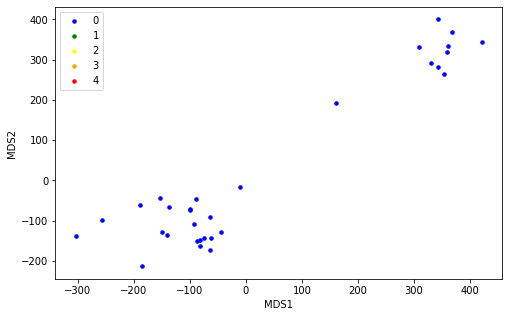

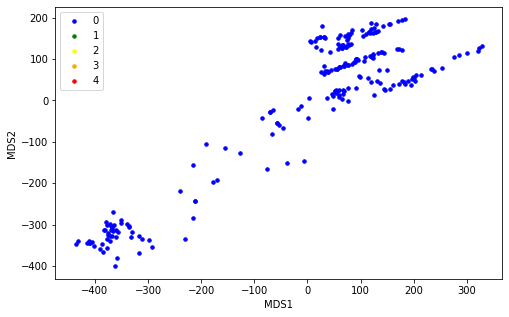

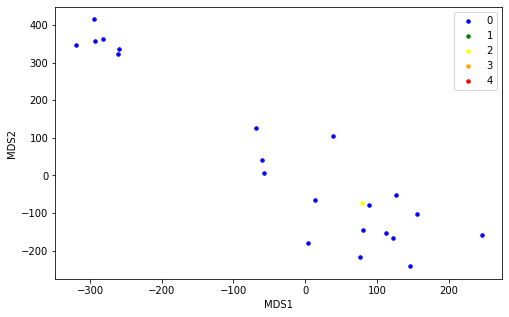

,MAE,MSE,RMSE,R2,Runtime
0,56.181300,9.771256e+03,98.849663,-14.975060,0.001294
1,420.458039,7.824539e+05,884.564249,-342.249841,0.001217
2,81.004997,3.374040e+04,183.685594,-49.896133,0.001349
3,27.386373,1.894954e+03,43.531065,-0.847608,0.001377
4,188.861098,1.180544e+05,343.590461,-130.497878,0.001607
5,28.516880,1.082522e+04,104.044303,-0.032173,0.001149
6,475.358707,1.147677e+06,1071.296927,-5104.915569,0.001190
7,112.950171,4.092860e+04,202.308183,-131.303019,0.001200
8,284.703010,2.939166e+05,542.140743,-308.623873,0.001678
9,153.529411,5.190252e+04,227.821239,-1.278404,0.001078


In [25]:
kfold = KFold(10, True, 99)
infoPolyMDS = []
model=make_pipeline(PolynomialFeatures(3), linear_model.Ridge(alpha=0.3))

for train, test in kfold.split(df):

    train = train.tolist()
    test = test.tolist()
    X_train=X[train] 
    X_test=X[test]
    yr_train=yr[train] 
    yr_test=yr[test]
    X_MDS_train = dimension_reduction('MDS',X_train,yr_train)
    X_MDS_test = dimension_reduction('MDS',X_test,yr_test)

    start = timeit.default_timer()

    model.fit(X_MDS_train,yr_train)
    stop = timeit.default_timer()
    timedif = stop - start
    R_squre_test = model.score(X_MDS_test,yr_test)
    MAE_test = mean_absolute_error(yr_test,model.predict(X_MDS_test))
    RMSE_test = mean_squared_error(yr_test, model.predict(X_MDS_test), squared=False)
    MSE_test = mean_squared_error(yr_test, model.predict(X_MDS_test))
    infoPolyMDS.append([MAE_test, MSE_test, RMSE_test, R_squre_test, timedif])
    
infoPolyMDS = pd.DataFrame(infoPolyMDS, columns=['MAE','MSE','RMSE','R2', 'Runtime'])
infoPolyMDS

## 8. Random Forest Polynomial Regression

In [26]:
def random_state_regression(train_idx,test_idx):
    
    start = timeit.default_timer()

    X_train = X[train_idx]
    X_test = X[test_idx]
    yc_train = yc[train_idx]
    yc_test = yc[test_idx]
    yr_train = yr[train_idx]
    yr_test = yr[test_idx]

    bestforest = RandomForestClassifier(criterion=best['criterion'], 
                                        max_depth=best['max_depth'], 
                                        max_features=best['max_features'],
                                        bootstrap=best['bootstrap'],
                                        random_state=i).fit(X_train, yc_train)

    pred = []

    try:
        mis_idx4, mis4, MAE4, MSE4, baseline4, r_square4 = error_label4(X_test,yr_test)
        baseline4 = (len(mis4)/len(yr_test))*baseline4
        MAE4 = (len(mis4)/len(yr_test))*MAE4
        MSE4 = (len(mis4)/len(yr_test))*MSE4
        pred.extend([1000]*len(mis_idx4))
        base = base + baseline4
        mae = mae + MAE4
        mse = mse + MSE4
    except:
        pass

    X1, y1 = filter_pred_idx(X_test,yr_test,1)
    X2, y2 = filter_pred_idx(X_test,yr_test,2)
    X3, y3 = filter_pred_idx(X_test,yr_test,3)
    
    try:
        pred0 = [0]*len(filter_pred_idx(X_test,yr,0)[1])
        pred.extend(pred0)
    except:
            pass
    try:
        df1 = regressors_gridsearch_extend(X1,y1)
        pred1 = (df1.shape[0]/len(yr_test))*df1.loc[df1['MAE'].idxmin(),:]['Pred']
        pred.extend(pred1.tolist())
        baseline1t = (df1.shape[0]/len(yr_test))*df1.loc[df1['MAE'].idxmin(),:]['Baseline Error']
        MAE1t = (df1.shape[0]/len(yr_test))*df1.loc[df1['MAE'].idxmin(),:]['MAE']
        MSE1t = (df1.shape[0]/len(yr_test))*df1.loc[df1['MAE'].idxmin(),:]['MSE']
        base = base + baseline1t
        mae = mae + MAE1t
        mse = mse + MSE1t
    except:
        pass

    try:
        df2 = regressors_gridsearch_extend(X2,y2)
        pred2 = (df2.shape[0]/len(yr_test))*df2.loc[df2['MAE'].idxmin(),:]['Pred']
        pred.extend(pred2.tolist())
        baseline2t = (df2.shape[0]/len(yr_test))*df2.loc[df2['MAE'].idxmin(),:]['Baseline Error']
        MAE2t = (df2.shape[0]/len(yr_test))*df2.loc[df2['MAE'].idxmin(),:]['MAE']
        MSE2t = (df2.shape[0]/len(yr_test))*df2.loc[df2['MAE'].idxmin(),:]['MSE']
        base = base + baseline2t
        mae = mae + MAE2t
        mse = mse + MSE2t
    except:
        pass

    try:
        df3 = regressors_gridsearch_extend(X3,y3)
        pred3 = (df3.shape[0]/len(yr_test))*df3.loc[df3['MAE'].idxmin(),:]['Pred']
        pred.extend(pred3.tolist())
        baseline3t = (df3.shape[0]/len(yr_test))*df3.loc[df3['MAE'].idxmin(),:]['Baseline Error']
        MAE3t = (df3.shape[0]/len(yr_test))*df3.loc[df3['MAE'].idxmin(),:]['MAE']
        MSE3t = (df3.shape[0]/len(yr_test))*df3.loc[df3['MAE'].idxmin(),:]['MSE']
        base = base + baseline3t
        mae = mae + MAE3t
        mse = mse + MSE3t
    except:
        pass
    
    yr_test = sorted(yr_test)
    pred = sorted(pred)
    mae = mean_absolute_error(yr_test,pred)
    mse = mean_squared_error(yr_test,pred)
    R2 = r2_score(yr_test, pred)
    rmse = mse**0.5
    stop = timeit.default_timer()
    timedif = stop - start
   
    return mae, mse, rmse, R2, timedif, yr_test, pred

In [27]:
kfold = KFold(10, True, 99)
info = []

for train, test in kfold.split(df):
    train = train.tolist()
    test = test.tolist()
    mae, mse, rmse, R2, timedf, y_test, y_pred = random_state_regression(train,test)
    info.append([mae, mse, rmse, R2, timedf, y_test, y_pred])
    
info = pd.DataFrame(info, columns=['MAE','MSE','RMSE','R2', 'Runtime', 'y_test','y_pred'])
info

,MAE,MSE,RMSE,R2,Runtime,y_test,y_pred
0,3.663195,165.217729,12.853705,0.729885,31.519969,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,21.516065,4980.635966,70.573621,-1.184924,51.976669,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,7.304083,436.086059,20.882674,0.342180,40.723688,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,16.781183,3218.901977,56.735368,-2.138477,46.160450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,14.943743,2782.741279,52.751695,-2.099627,45.639794,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,15.649157,7027.166831,83.828198,0.329967,23.840585,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,13.819970,834.723060,28.891574,-2.713610,27.578301,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,6.813329,258.497850,16.077868,0.164397,27.043163,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,4.574002,172.642677,13.139356,0.818131,22.174539,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,23.599689,15981.001095,126.415984,0.298470,28.207454,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
